<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/08-object-detection/02_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Object detection

We’ll now
learn how a more involved approach, with multiple components working together, can perform bounding-box-based object detection. This strategy finds objects in one pass,
and a second step determines what specific object is present at a location.

We want the model to detect objects by drawing a box around any object of interest.
Since objects could be at weird sizes or angles, the goal is that the box should bound
the object, so the box should be just big enough to fit the entire object within the box.

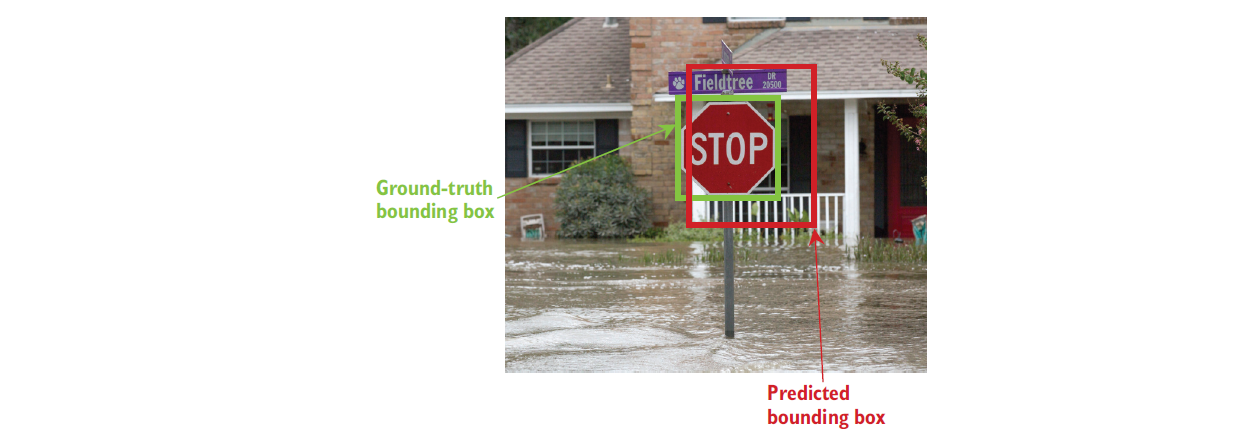

In particular, we go over an algorithm called Faster R-CNN,4 which has become the
de facto baseline for object detection.

The three steps we described can be broken into three subnetworks: 
* a backbone network to extract feature maps, 
* a region proposal network (RPN) to find objects,
* and a region of interest pooling (RoI pooling or just RoI) network that predicts what type of object is being looked at.

We will not implement Faster R-CNN from scratch because it has a number of
important details and takes hundreds of lines of code to implement in total.

If you want the minutia, check out the article **[Object Detection
and Classification using R-CNNs](https://www.telesens.co/2018/03/11/object-detection-and-classification-using-r-cnns/)**.

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import set_seed
from idlmam import train_network, Flatten, View, weight_reset, moveTo

In [3]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

Our toy dataset will be a larger `100x100`
image containing a random number of
MNIST digits in random locations. The goal will be to detect where these images are and classify them correctly.

In [22]:
class Class2Detect(Dataset):
  """
  This class is used to create a simple converstion of a dataset from a classification problem, to a detection problem.
  """
  def __init__(self, dataset, toSample=3, canvas_size=100):
    """
    dataset: the source dataset to sample items from as the "objects" to detect
    toSample: the maximum number of "objects" to put into any image
    canvas_size: the width and height of the images to place objects inside of.
    """
    self.dataset = dataset
    self.toSample = toSample 
    self.canvas_size = canvas_size 

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    boxes = []
    labels = []
    final_size = self.canvas_size

    # First, create a larger image that will store all the "objects" to detect
    img_path = torch.zeros((final_size, final_size), dtype=torch.float32)
    
    # Now we are going to sample up to self.toSample objects to place into the image
    for _ in range(np.random.randint(1, self.toSample + 1)):
      # Pick an object at random from the original dataset, and its label
      img, label = self.dataset[np.random.randint(0, len(self.dataset))]
      # Get the height and width of that image
      _, img_h, img_w = img.shape
      # Pick a random offset of the x and y axis, essentially placing the image at a random location
      offsets = np.random.randint(0, final_size - np.max(img.shape), size=(4))
      # Change the padding at the end to make sure we come out to a specific 100,100 shape
      offsets[1] = final_size - img.shape[1] - offsets[0]
      offsets[3] = final_size - img.shape[2] - offsets[2]

      with torch.no_grad():
        img_path = img_path + F.pad(img, tuple(offsets))

      # Lets craete the values for the "boxes", all of these are in absolute pixel locations
      # x_min determined by the randomly selected offset
      xmin = offsets[0]
      # x_max is the offset plus the image's width
      xmax = offsets[0] + img_w
      # y min/max follows the same pattern
      ymin = offsets[2]
      ymax = offsets[2] + img_h
      # now we add to the box with the right label
      boxes.append([xmin, ymin, xmax, ymax])
      labels.append(label)

    target = {}
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
    
    return img_path, target

Now that we can load the dataset.

In [23]:
train_data = Class2Detect(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))
test_data = Class2Detect(torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True))

Faster R-CNN is designed to work with images of highly variable size, so we would not have the same W and H values for every item. 

Instead, Faster R-CNN
wants a list of tensors and a list of dictionaries. We have to use a custom collate
function to make that happen.

In [24]:
def collate_fn(batch):
  """
  batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
  The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. 
  So we will use this function to convert the batch of data into the form we want, and then give it to the Dataloader to use
  """
  imgs = []
  labels = []
  for img, label in batch:
    imgs.append(img)
    labels.append(label)
  return imgs, labels

In [25]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)

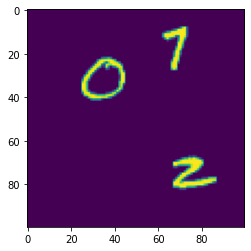

In [26]:
# Grab an image with its labels
x, y = train_data[0]

imshow(x.numpy()[0, :])

In [27]:
# Let’s look at the label object, y.
print(y)

# prints a tensor showing the pixel locations of the corners for all 3 objects
print(f"Boxes: {y['boxes']}")
# prints a tensor showing the labels for all 3 objects
print(f"Labels: {y['labels']}")

{'boxes': tensor([[61., 61., 89., 89.],
        [54.,  2., 82., 30.],
        [20., 17., 48., 45.]]), 'labels': tensor([2, 7, 0])}
Boxes: tensor([[61., 61., 89., 89.],
        [54.,  2., 82., 30.],
        [20., 17., 48., 45.]])
Labels: tensor([2, 7, 0])


##Faster R-CNN Model

Let's define some parameters.

In [ ]:
C = 3         # How many channels are in the input?
n_filters = 32  # Smallest value of filters should usually be considered. If we wanted to try and optimize the architecture we could use Optuna to pick a better number of filters. 
loss_func = nn.BCEWithLogitsLoss()  # BCE loss implicitly assumes a binary problem

Because we need to make predictions for every pixel, our network’s output `f(.)` must
have a shape with the same height and width as our original inputs.

The easiest way to keep the sameW and H values is to never use pooling and to always
use padding so the output is the same size as the input.

Let's incorporates both of these choices into a simple neural network.

In [ ]:
def cnn_layer(in_filters, out_filters, kernel_size=3):
  """
  in_filters: how many channels are in the input to this layer
  out_filters: how many channels should this layer output
  kernel_size: how large should the filters of this layer be
  """
  padding = kernel_size // 2
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.BatchNorm2d(out_filters),
    nn.LeakyReLU()
  )

In [ ]:
# Specifying a model for image segmentation
segmentation_model = nn.Sequential(
  # First layer changes number of channels up to the large numer
  cnn_layer(C, n_filters),
  # Create 5 more hidden layers
  *[cnn_layer(n_filters, n_filters) for _ in range(5)],
  # Make a prediction for every location. Notice we use 1 channel out, since we have a binary problem and are using BCEWithLogitsLoss as our loss function. 
  nn.Conv2d(n_filters, 1, (3, 3), padding=1)  # Shape is now (1, W, H)
)

In [ ]:
# Trains the segmentation model
segmentation_results = train_network(segmentation_model, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

Text(-240, -50, 'Error: Phantom object')

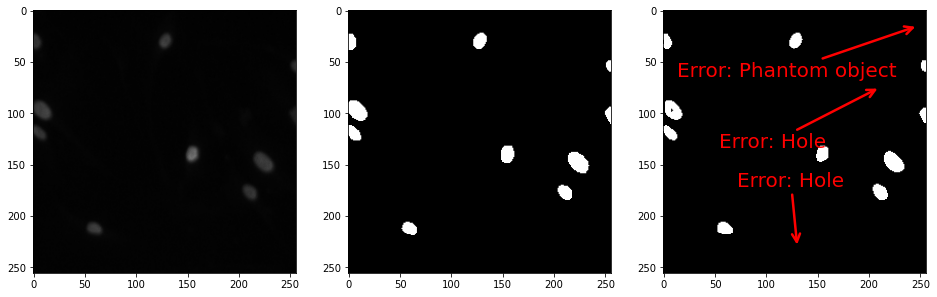

In [ ]:
# let’s visually inspect some of the results
index = 6  # Picking a specific example from the dataset that shows a particular result

with torch.no_grad():
  # push a test datapoint through the model. Remember the raw outputs are called the logits
  logits = segmentation_model(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
  # apply sigmoid to the logits to make predictions and then apply a threshold to get a prediction mask
  pred = torch.sigmoid(logits) >= 0.5

# Plot the input, ground truth, and prediction
plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1, 2, 0).numpy(), cmap="gray")  # First plot the original input to the network
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0, :], cmap="gray")  # Second is ground truth
plt.subplot(1, 3, 3)
plt.imshow(pred.numpy()[0, :], cmap="gray")  # Third is the prediction our network made

plt.annotate("Error: Hole", color="red", fontsize=20, xy=(130, 230),
             xycoords="data", xytext=(-60, 60),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", linewidth=2.5, color="red"))
plt.annotate("Error: Hole", color="red", fontsize=20, xy=(210, 75),
             xycoords="data", xytext=(-160, -60),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", linewidth=2.5, color="red"))
plt.annotate("Error: Phantom object", color="red", fontsize=20, xy=(247, 15),
             xycoords="data", xytext=(-240, -50),
             textcoords="offset points", arrowprops=dict(arrowstyle="->", linewidth=2.5, color="red"))

##Transposed convolutions

We prefer to somehow use pooling so that we get the benefits of a smaller output (less
memory) and larger receptive field, and then later expand back up to a larger form. We
can do this with what is called a transposed convolution. 

In a normal convolution, the
value of one output is determined by multiple inputs. Because each output has multiple
inputs, the output is smaller than the input so each output gets its full contribution. 

An easy way to think about transposed convolutions is to imagine that one input contributes
to multiple outputs.

The important thing to remember here is that transposed convolutions give us a way
to expand back up in size.

With a transposed convolution, we can expand a network’s output, which means we
can use pooling and then undo the reduction in width and height later. 

Let’s try it
to see if this provides any real value to our model.

In [ ]:
# Specifying a model for image segmentation
segmentation_model2 = nn.Sequential(
  # First layer changes number of channels up to the large numer
  cnn_layer(C, n_filters),
  cnn_layer(n_filters, n_filters),
  # Shrinks the height and width by 2
  nn.MaxPool2d(2),    
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters, 2 * n_filters), 

  # Double the height and width, countering the effect of the single MaxPool2d before
  nn.ConvTranspose2d(2 * n_filters, n_filters, (3, 3), padding=1, output_padding=1, stride=2),
  nn.BatchNorm2d(n_filters),
  nn.LeakyReLU(),
  
  # Back to normal convolutions
  cnn_layer(n_filters, n_filters),
  # Prediction for every location
  nn.Conv2d(n_filters, 1, (3, 3), padding=1)  # Shape is now (1, W, H)
)

In [ ]:
# Trains the segmentation model
segmentation_results2 = train_network(segmentation_model2, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

Now that we have trained this new model, let’s try it on the same data and see what
happens.

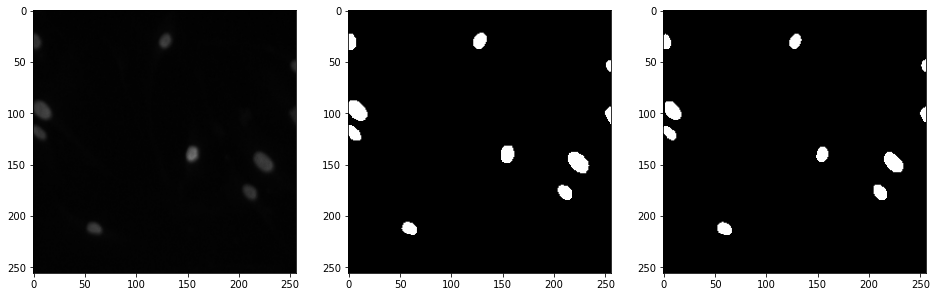

In [ ]:
# let’s visually inspect some of the results
index = 6  # Picking a specific example from the dataset that shows a particular result

with torch.no_grad():
  # push a test datapoint through the model. Remember the raw outputs are called the logits
  logits = segmentation_model2(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
  # apply sigmoid to the logits to make predictions and then apply a threshold to get a prediction mask
  pred = torch.sigmoid(logits) >= 0.5

# Plot the input, ground truth, and prediction
plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)

plt.imshow(test_split[index][0].permute(1, 2, 0).numpy(), cmap="gray")  # First plot the original input to the network
plt.subplot(1, 3, 2)

plt.imshow(test_split[index][1].numpy()[0, :], cmap="gray")  # Second is ground truth
plt.subplot(1, 3, 3)

plt.imshow(pred.numpy()[0,:], cmap='gray') #Third is the prediction our network made

Working
on a smaller representation (the rounds after pooling) helps to encourage softer and
smoother masks in our output. 

But we should never look at just a single image to decide
if we’ve made an improvement, so let’s check the validation loss:

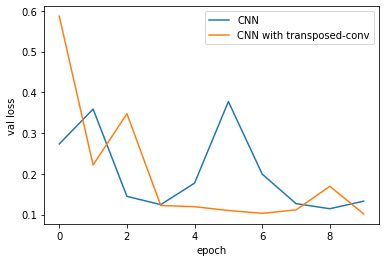

In [ ]:
sns.lineplot(x="epoch", y="val loss", data=segmentation_results, label="CNN")
sns.lineplot(x="epoch", y="val loss", data=segmentation_results2, label="CNN with transposed-conv")

In [ ]:
del segmentation_model
del segmentation_model2

According to the validation error, we have overall done a slightly better job than before.
Something that is often just as important is learning speed, and we can see that this
approach was able to make faster progress in fewer epochs of training. 

This faster
learning is a significant benefit, and its importance grows as we work on harder and
larger problems.

##U-Net

Right now, we have two ways to model the image segmentation problem. The first
approach uses no pooling and performs many rounds of convolutional
layers. This makes a model that can look at minute fine-grained details but can literally
miss the forest for the trees.

The second uses rounds of max pooling followed by transposed
convolution layers at the end of the architecture. You can think of this approach as
progressively looking at higher-level regions of the image. The more rounds of pooling
you do, the higher the model looks to make decisions.

Max pooling/up-sampling works well for detecting larger objects and broad borders,
and the fine-grained model works better for small objects and nuanced object borders.
We want a way to get the best of both worlds, capturing both fine details and high-level
things simultaneously.

We can achieve this best-of-both-worlds by including skip connections 
into our approach. Doing so creates an architecture approach known as U-Net,3 where
we create three subnetworks to process the input:

* An input subnetwork that applies hidden layers to the full-resolution (lowest level of features) input.
* A bottleneck subnetwork that is applied after max pooling, allowing it to look at a
lower resolution (higher-level features), and then uses a transposed convolution
to expand its results back up to the same width and height as the original input.
* An output subnetwork that combines the results from the two proceeding networks.
This lets it get the best of both worlds, looking at low- and high-level details simultaneously.

Expanding this into a larger U-Net architecture is done by repeatedly making the
bottleneck subnetwork be another U-Net block. This way, you get a network that learns to
look at multiple different resolutions at once.

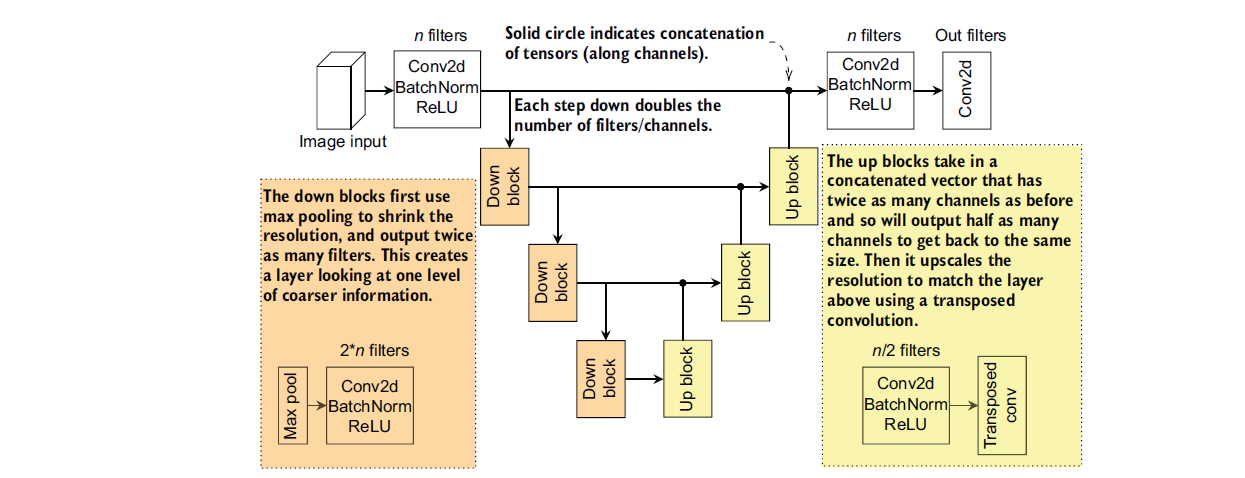

To make our implementation simpler, we take in the number of `in_channels` and
use `mid_channels` as how many filters should be used in the convolutions. 

If we want the output to have a different number of channels, we use a `1 x 1` convolution to change mid_channels to `out_channels`. 

Since each block can have multiple layers, we
make that an argument as well. The last thing we need is the `sub_network` used as the bottleneck.

In [ ]:
class UNetBlock2d(nn.Module):

  def __init__(self, in_channels, mid_channels, out_channels=None, layers=1, sub_network=None, filter_size=3):
    """
    in_channels: the number of channels in the input to this block
    mid_channels: the number of channels to have as the output for each convolutional filter
    out_channels: if not `None`, ends the network with a 1x1 convolution to convert the number of output channels to a specific number. 
    layers: how many blocks of hidden layers to create on both the input and output side of a U-Net block
    sub_network: the network to apply after shrinking the input by a factor of 2 using max pooling. The number of output channels should be equal to `mid_channels`
    filter_size: how large the convolutional filters should be
    """
    super().__init__()

    # Start preparing the layers used to process the input
    in_layers = [cnn_layer(in_channels, mid_channels, filter_size)]

    # If we have a sub-network, we will double the number of inputs to the output
    if sub_network is None:
      inputs_to_outputs = 1
    else:
      inputs_to_outputs = 2

    # Preparing the layers used to make the final output, which has extra input channels from any sub-network
    out_layers = [cnn_layer(mid_channels * inputs_to_outputs, mid_channels, filter_size)]

    # Make the additional hidden layers used for the input and output
    for _ in range(layers - 1):
      in_layers.append(cnn_layer(mid_channels, mid_channels, filter_size))
      out_layers.append(cnn_layer(mid_channels, mid_channels, filter_size))

    # Use 1x1 Convolutions to ensure a specific output size
    if out_channels is not None:
      out_layers.append(nn.Conv2d(mid_channels, out_channels, 1, padding=0))

    # define our three total sub-networks

    # 1) in_model performs the intial rounds of convolution
    self.in_model = nn.Sequential(*in_layers)

    # 2) our subnetwork works on the max-pooled result. We will add the pooling and up-scaling directly into the sub-model
    if sub_network is not None:
      self.bottleneck = nn.Sequential(
        nn.MaxPool2d(2),  # Shrink
        sub_network,      # process the smaller resolution
        nn.ConvTranspose2d(mid_channels, mid_channels, filter_size, padding=filter_size//2, output_padding=1, stride=2)
      )
    else:
      self.bottleneck = None

    # 3) the output model that processes the concatinated result, or just the output from in_model if no sub-network was given
    self.out_model = nn.Sequential(*out_layers)

  def forward(self, x):
    # compute the convolutions at the current scale
    full_scale_result = self.in_model(x)   # (B, C, W, H)

    # check if we have a bottleneck to apply
    if self.bottleneck is not None:
      # (B, C, W, H) shape because bottleneck does both the pooling & expansion
      bottle_result = self.bottleneck(full_scale_result)
      # Now shape (B, 2*C, W, H)
      full_scale_result = torch.cat([full_scale_result, bottle_result], dim=1)
    # compute the output on the concatenated (or not!) result
    return self.out_model(full_scale_result)


With this one `UNetBlock2d` module, we can implement an entire U-Net architecture by specifying that the `sub_network` itself be another `UNetBlock2d`. We can then just repeat this as many
times as we like.

In [ ]:
unet_model = nn.Sequential(
  UNetBlock2d(3, 32, layers=2,   
      sub_network=UNetBlock2d(32, 64, out_channels=32, layers=2,
          sub_network=UNetBlock2d(64, 128, out_channels=64, layers=2)
      ),
  ),
  # Prediction for _every_ location
  nn.Conv2d(32, 1, (3, 3), padding=1)  # Shape is now (B, 1, W, H)
)

In [ ]:
# Trains the segmentation model
unet_results = train_network(unet_model, loss_func, train_seg_loader, epochs=10, device=device, val_loader=test_seg_loader)

Now that we have trained this model, let’s plot the results compared to our first two
segmentation models.

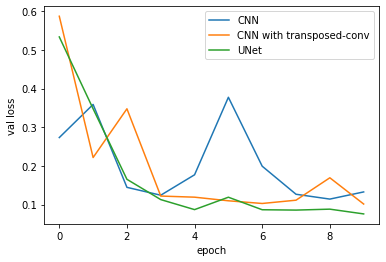

In [ ]:
sns.lineplot(x="epoch", y="val loss", data=segmentation_results, label="CNN")
sns.lineplot(x="epoch", y="val loss", data=segmentation_results2, label="CNN with transposed-conv")
sns.lineplot(x="epoch", y="val loss", data=unet_results, label="UNet")

Notice that the U-Net approach is the best of both worlds, giving
us both lower total loss and learning faster than either the fine- or coarse-grained
models from earlier.

The U-Net approach is a strong starting point for any image segmentation problem or
any related tasks where you need to make a prediction about multiple points within
an image.